# Analysing pre-trained language models with topic models

In [2]:
# Library imports
import random
import numpy as np
import os.path
import logging
import random
import itertools
from operator import itemgetter
from gensim.test.utils import datapath
import re
import json
from gensim.models.ldamulticore import LdaMulticore
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
from matplotlib.patches import Rectangle
from nltk.tokenize import RegexpTokenizer
from pprint import pprint
from gensim.utils import SaveLoad
from gensim.corpora import Dictionary
from pathlib import Path
from tqdm.auto import tqdm
import gc
import torch
from datasets import load_dataset
from transformers import set_seed
from transformers import AutoModelForCausalLM, GPT2LMHeadModel, GPTNeoForCausalLM
from transformers import AutoTokenizer, GPT2Tokenizer
from gensim.models import Phrases
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from wordcloud import WordCloud

# Seed for reproducability
set_seed(42)

# Tensorflow or Pytorch
framework = "pt"     # "tf" but not configured for that

# Use GPU or CPU
use_gpu = True
torch.set_num_threads(torch.get_num_threads()*2-2)
device = "cuda" if torch.cuda.is_available() and use_gpu else "cpu"

# params
corpus_size = 1e6   # depending on the number of topics created with lda

gc.collect()
torch.cuda.empty_cache()

## Experimenting individual functions on small data

### Removing Wikitext 103 Titles

In [ ]:
def removing_wikitext_titles(file_name):
    r"""
    Removing Titles and replacing them with one empty line between each text

    :param file_name: location of the file with titles
    """
    new_file_name = file_name+'_no_titles.txt'
    if not os.path.isfile(new_file_name):
        str0 = Path(file_name).read_text(encoding='utf-8')
        heading_pattern = '( \n [=\s].*[=\s] \n)'
        str1 = re.sub(heading_pattern, '\n\n', str0)
        str2 = re.sub('\n\n+[\n]', '\n\n', str1)
        with open(file=new_file_name, mode='x', encoding='utf-8') as file:
            file.write(str2)
    else:
        print("ERROR: File already exists. Must be deleted manually.")

train = './data/data_wikitext-103-raw/wiki.train.raw'
test = './data/data_wikitext-103-raw/wiki.test.raw'
valid = './data/data_wikitext-103-raw/wiki.valid.raw'
removing_wikitext_titles(train)
removing_wikitext_titles(test)
removing_wikitext_titles(valid)

### Training your own language model

`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --dataset_name wikitext --dataset_config_name wikitext-103-raw-v1 --output_dir data/test --do_eval --do_train --block_size 1024 --overwrite_output_dir`

or

`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --output_dir data/test --do_eval --do_train --block_size 1024 --overwrite_output_dir --train_file .\data\data_wikitext-103-raw\wiki.train.raw.txt --validation_file .\data\data_wikitext-103-raw\wiki.valid.raw.txt`

**For validation/perplexity score only:**
`python run_clm.py --model_type gpt2 --tokenizer_name gpt2 --output_dir data/test --do_eval --block_size 1024 --overwrite_output_dir --validation_file .\data\data_wikitext-103-raw\wiki.valid.raw.txt`

### Generating documents from selected pre-trained language models

In [3]:
def create_corpus(
        tokenizer_name="gpt2",
        model_name="gpt2",
        max_document_length=None,
        device="cpu",
        corpus_size=1,
        tokenizer_model=AutoTokenizer,
        lm_model=AutoModelForCausalLM,
        pad_token_id=None,
        save_path="data/test",
        load_size=1
    ):
    r"""
    Generates sequences/documents/a corpus for models with a language modeling head.

    Parameters:
        corpus_size (`int`, *optional*, defaults to 1):
            The corpus size to be generated (number of documents)
        model_name (`str`, *optional*, defaults to "openai-gpt"):
            The model name of the pre-trained model: openai-gpt, gpt2-small, gpt2, gpt2-large, gpt2-xl, transfo-xl-wt103, EleutherAI/gpt-neo-2.7B, ctrl
        max_document_length (`int`, *optional*, defaults to None):
            The maximum document length, normally set to tokenizer.max_length
        tokenizer_model (`PreTrainedTokenizer`, *optional*, defaults to AutoTokenizer):
            The pre-trained tokenizer class
        lm_model (`PreTrainedModel`, *optional*, defaults to AutoModelForCausalLM):
            The pre-trained model class with language modeling head
        device (`str`, *optional*, defaults to "cpu"):
            The device the computations commence "cpu" or "cuda"
    """

    if os.path.isfile(save_path):
        print("ERROR: file already exist, please remove manually before running again.")
        return

    tokenizer = tokenizer_model.from_pretrained(tokenizer_name)
    model = lm_model.from_pretrained(model_name)

    max_document_length = max_document_length if max_document_length is not None else tokenizer.model_max_length
    if pad_token_id is not None:
        if pad_token_id == 'eos_token_id':
            pad_token_id = tokenizer.eos_token_id
        else:
            print("ERROR: Undefinded/unimplemented pad_token_id")

    # print(f"EOS: {tokenizer.eos_token} | BOS: {tokenizer.bos_token} | UNK: {tokenizer.unk_token}")

    model = model.to(device)

    decoded_output = []

    for i in tqdm(range(0, corpus_size, load_size)):
        step_size = min(load_size, corpus_size-i)
        encoded_output = model.generate(
            # all parameters have to be set as otherwise the config of the pretrained model will be taken
            input_ids=None,
            max_length=max_document_length,
            do_sample=True,                         # False implies Greedy search
            early_stopping=False,
            num_beams=1,                            # 1 deactivates beam_search
            temperature=1.0,                        # 1.0 deactivates temperature
            top_k=0,                                # 0 deactivates top_k sampling
            top_p=1.0,                              # 1.0 deactivates top_p sampling
            repetition_penalty=1.0,                 # 1.0 deactivates repetition_penalty
            pad_token_id=pad_token_id,              # For open-end generation set to eos_token_id
            #bos_token_id=bos_token_id,
            #eos_token_id=eos_token_id,
            length_penalty=1.0,                     # 1.0 deactivates length_penalty
            no_repeat_ngram_size=0,                 # 0 deactivates no_repeat_ngram_size
            encoder_no_repeat_ngram_size=0,         # 0 deactivates encoder_no_repeat_ngram_size
            num_return_sequences=step_size,       # The number of independently computed returned sequences for each element in the batch. No input means batch size of one.
            num_beam_groups=1,
            output_scores=False,                    # Will be important if you want the prediction scores!
        )

        for j in range(load_size):
            decoded_output.append(tokenizer.decode(encoded_output[j], skip_special_tokens=True))

    with open(save_path, 'w') as file:
        json.dump(decoded_output, file, indent=2)

    gc.collect()
    torch.cuda.empty_cache()

<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\franz\AppData\Local\Temp/ipykernel_32996/2422776061.py:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if pad_token_id is 'eos_token_id':


In [4]:
create_corpus(
    tokenizer_name="gpt2",
    model_name="./data/model-gpt2-wiki_nt",
    max_document_length=None,
    device=device,
    corpus_size=1000,
    tokenizer_model=GPT2Tokenizer,
    lm_model=GPT2LMHeadModel,
    pad_token_id='eos_token_id',
    save_path="data/test.json",
    load_size=10
)

ERROR: file already exist, please remove manually before running again.


In [7]:
create_corpus(
    tokenizer_name="gpt2",  # "EleutherAI/gpt-neo-2.7B"
    model_name="gpt2",  # "EleutherAI/gpt-neo-2.7B"
    max_document_length=None,   # 2048
    device=device,
    corpus_size=1000,
    tokenizer_model=GPT2Tokenizer,
    lm_model=GPT2LMHeadModel,   # GPTNeoForCausalLM
    pad_token_id='eos_token_id',
    save_path="data/data_gpt2.json",
    load_size=5
)

  0%|          | 0/100 [00:00<?, ?it/s]

### Training an LDA Model (Latent Dirichlet Allocation)

In [10]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [22]:
def load_json(filename, samples=100000):
    with open(filename, 'r') as file:
        train_articles = json.load(file)
    return random.sample(train_articles, k=samples)

In [23]:
def load_arxiv(samples=100000):
    def get_metadata():
        with open('data/data_arxiv-metadata-oai-snapshot.json', 'r') as f:
            for line in f:
                yield line

    metadata = get_metadata()
    size = 0
    for paper in metadata:
        size += 1
    choices = random.sample(list(np.arange(size)), k=samples)
    choices.sort()
    metadata = get_metadata()
    step = 0
    idx = 0
    corpus = []
    for paper in metadata:
        if idx >= samples:
            break
        if step == choices[idx]:
            idx += 1
            corpus.append(json.loads(paper)['abstract'])
        step += 1
    return corpus

In [24]:
def load_wikitext(samples=100000):
    heading_pattern = '( \n [=\s].*[=\s] \n)'
    train_data = Path('data/data_wikitext-103-raw/wiki.train.raw').read_text(encoding='utf-8')
    train_split = re.split(heading_pattern, train_data)
    train_headings = [x[7:-7] for x in train_split[1::2]]
    train_articles = [x for x in train_split[2::2]]
    return random.sample(train_articles, k=samples)

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\franz\AppData\Local\Temp/ipykernel_30156/2425308730.py:2: DeprecationWarning: invalid escape sequence \s
  heading_pattern = '( \n [=\s].*[=\s] \n)'


In [25]:
def tokenize(docs):
    # Tokenize the documents.
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    # Lemmatize the documents. Better than stemmer as is easier to read
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Remove rare and common tokens.
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.5)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    return dictionary, corpus

In [26]:
def tokenize_special(docs0, docs1, union=False):  # False is intersection
    # Tokenize the documents.
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')

    for idx in range(len(docs0)):
        docs0[idx] = docs0[idx].lower()  # Convert to lowercase.
        docs0[idx] = tokenizer.tokenize(docs0[idx])  # Split into words.
    for idx in range(len(docs1)):
        docs1[idx] = docs1[idx].lower()  # Convert to lowercase.
        docs1[idx] = tokenizer.tokenize(docs1[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs0 = [[token for token in doc if not token.isnumeric()] for doc in docs0]
    docs1 = [[token for token in doc if not token.isnumeric()] for doc in docs1]

    # Remove words that are only one character.
    docs0 = [[token for token in doc if len(token) > 1] for doc in docs0]
    docs1 = [[token for token in doc if len(token) > 1] for doc in docs1]

    # Lemmatize the documents. Better than stemmer as is easier to read
    lemmatizer = WordNetLemmatizer()
    docs0 = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs0]
    docs1 = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs1]

    # Add bigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs0, min_count=20)
    for idx in range(len(docs0)):
        for token in bigram[docs0[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs0[idx].append(token)
    bigram = Phrases(docs1, min_count=20)
    for idx in range(len(docs1)):
        for token in bigram[docs1[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs1[idx].append(token)

    # Remove rare and common tokens.
    # Create a dictionary representation of the documents.
    dic0 = Dictionary(docs0)
    dic1 = Dictionary(docs1)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dic0.filter_extremes(no_below=20, no_above=0.5)
    dic1.filter_extremes(no_below=20, no_above=0.5)

    if union:
        transformer = dic0.merge_with(dic1)
    else:
        good_ids0 = []
        good_ids1 = []
        for good_value in set(dic0.values()).intersection(set(dic1.values())):
            good_ids0.append(dic0.token2id[good_value])
            good_ids1.append(dic1.token2id[good_value])
        dic0.filter_tokens(good_ids=good_ids0)

    dic1 = dic0

    # Bag-of-words representation of the documents.
    cor0 = [dic0.doc2bow(doc) for doc in docs0]
    cor1 = [dic1.doc2bow(doc) for doc in docs1]
    print('Number of unique tokens in dic0: %d' % len(dic0))
    print('Number of unique tokens in dic1: %d' % len(dic1))
    print('Number of documents of cor0: %d' % len(cor0))
    print('Number of documents of cor1: %d' % len(cor1))

    return dic0, cor0, dic1, cor1

In [27]:
def train_lda(dictionary, corpus):
    # Train LDA model.

    # Set training parameters.
    num_topics = 4
    chunksize = 100000
    passes = 20
    iterations = 300
    eval_every = None  # Evaluating model perplexity takes a lot of time.

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaMulticore(
        corpus=corpus,
        num_topics=num_topics,
        id2word=id2word,
        workers=4,
        chunksize=chunksize,
        passes=passes,
        alpha='symmetric',
        eta='auto',
        eval_every=eval_every,
        iterations=iterations,
    )

    top_topics = model.top_topics(corpus)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print('Average topic coherence: %.4f.' % avg_topic_coherence)

    pprint(top_topics)

    return model

In [ ]:
data_train_1 = load_wikitext()
data_train_2 = load_arxiv()
dictionary_1, corpus_1, dictionary_2, corpus_2 = tokenize_special(data_train_1, data_train_2, True)

In [ ]:
ldamodel_1 = train_lda(dictionary_1, corpus_1)
ldamodel_2 = train_lda(dictionary_2, corpus_2)

### Load pre-trained LDA Models

In [23]:
path1 = "lda-gpt2_nt-wiki_nt/wiki_nt"
path2 = "lda-gpt2_nt-wiki_nt/gpt2_nt"
topics = 10
mode = "union"   # "union", "intersection"

path_ldamodel_1 = f"data/{path1}/{mode}/{topics}/ldamodel_{topics}"
path_ldamodel_2 = f"data/{path2}/{mode}/{topics}/ldamodel_{topics}"
path_dictionary_1 = f"data/{path1}/{mode}/{topics}/dictionary_{topics}"
path_dictionary_2 = f"data/{path2}/{mode}/{topics}/dictionary_{topics}"
path_corpus_1 = f"data/{path1}/{mode}/{topics}/corpus_{topics}"
path_corpus_2 = f"data/{path2}/{mode}/{topics}/corpus_{topics}"

# Load pretrained model from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

gamma_1, _ = ldamodel_1.inference(corpus_1)
doc_topic_dist_1 = gamma_1 / gamma_1.sum(axis=1)[:, None]

gamma_2, _ = ldamodel_2.inference(corpus_2)
doc_topic_dist_2 = gamma_2 / gamma_2.sum(axis=1)[:, None]

### Visualizing an LDA Model

In [22]:
# pcoa, mmds, tsne
vis_data_wiki = gensimvis.prepare(ldamodel_1, corpus_1, dictionary_1, mds='tsne', sort_topics=True)
pyLDAvis.display(vis_data_wiki)

c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' wil

In [21]:
vis_data_gpt = gensimvis.prepare(ldamodel_2, corpus_2, dictionary_2, mds='tsne', sort_topics=True)
pyLDAvis.display(vis_data_gpt)

c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\users\franz\pycharmprojects\venv3.9\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' wil

### Comparing two LDA Models

In [15]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', vmin=0.0, vmax=1.0, origin='lower')
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(MaxNLocator(integer=True))
    plt.title(title)
    plt.colorbar(data)
    for (i, j) in [(0,1), (2,2)]:
        ax.add_patch(Rectangle((j-.5, i-.5), 1, 1, 0.0, fill=None, ec='black', lw=50/topics))
    #plt.savefig(f"./data/test_{topics}.png", dpi=300)

distance = 'jensen_shannon' # 'kullback_leibler', 'hellinger', 'jaccard', 'jensen_shannon'
num_words = 1000000000

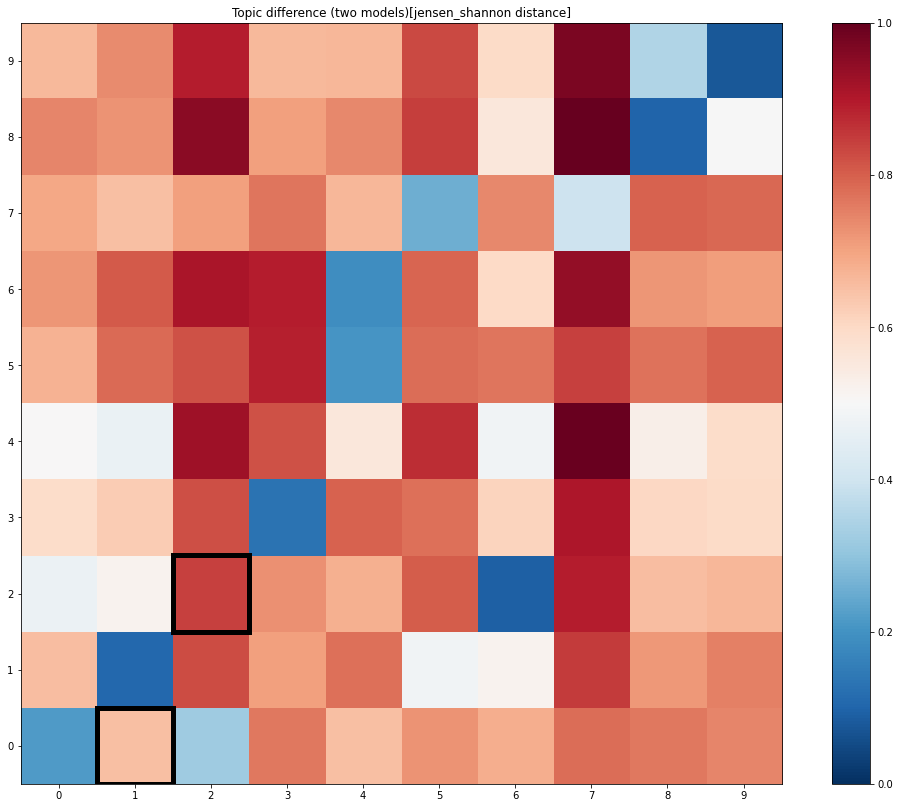

In [16]:
mdiff, annotation = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=num_words)
plot_difference_matplotlib(mdiff, title=f"Topic difference (two models)[{distance} distance]", annotation=annotation)

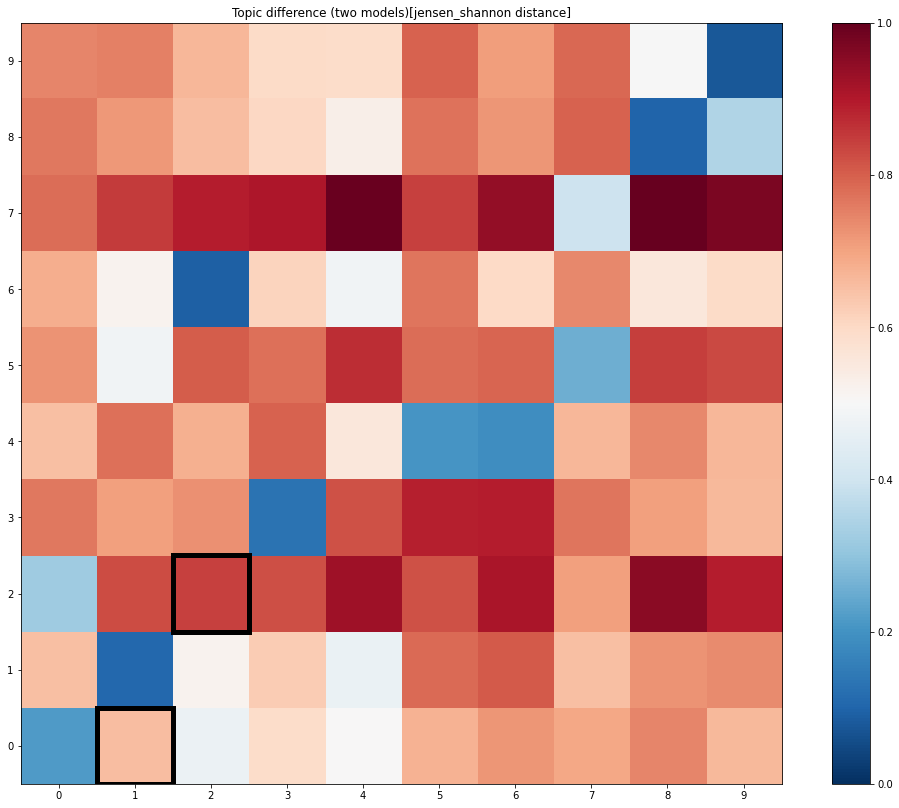

In [17]:
mdiff, annotation = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=num_words)
plot_difference_matplotlib(mdiff, title=f"Topic difference (two models)[{distance} distance]", annotation=annotation)

### Score function for evaluating how equal two LDA Models are

In [10]:
def score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2, distance='jensen_shannon'):
    mdiff1, annotation1 = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
    mdiff2, annotation2 = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=1000000000)
    min1 = np.amin(mdiff1, axis=1)
    min2 = np.amin(mdiff2, axis=1)
    topic_corpus_prob_1 = np.zeros(ldamodel_1.num_topics)
    topic_corpus_prob_2 = np.zeros(ldamodel_2.num_topics)
    probas_1 = ldamodel_1.get_document_topics(list(itertools.chain.from_iterable(corpus_1)), minimum_probability=0.0)
    probas_2 = ldamodel_2.get_document_topics(list(itertools.chain.from_iterable(corpus_2)), minimum_probability=0.0)
    for key, val in probas_1:
        topic_corpus_prob_1[key] = val
    for key, val in probas_2:
        topic_corpus_prob_2[key] = val
    return (np.sum(topic_corpus_prob_1 * min1) + np.sum(topic_corpus_prob_2 * min2)) / 2


def score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2, distance='jensen_shannon'):
    mdiff1, annotation1 = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
    mdiff2, annotation2 = ldamodel_2.diff(ldamodel_1, distance=distance, num_words=1000000000)
    min1 = np.amin(mdiff1, axis=1)
    min2 = np.amin(mdiff2, axis=1)

    cnt1 = np.zeros(ldamodel_1.num_topics)
    for doc in corpus_1:
        topic_prob_list = ldamodel_1.get_document_topics(doc, minimum_probability=0.0)
        topic_prob_tupel = max(topic_prob_list, key=itemgetter(1))
        cnt1[topic_prob_tupel[0]] += 1
    cnt2 = np.zeros(ldamodel_1.num_topics)
    for doc in corpus_2:
        topic_prob_list = ldamodel_2.get_document_topics(doc, minimum_probability=0.0)
        topic_prob_tupel = max(topic_prob_list, key=itemgetter(1))
        cnt2[topic_prob_tupel[0]] += 1

    return (np.sum(cnt1 * min1) / np.sum(cnt1) + np.sum(cnt2 * min2) / np.sum(cnt2)) / 2

In [2]:
model_pair = ("lda-wiki_nt-gpt2_nt/wiki_nt", "lda-wiki_nt-gpt2_nt/gpt2_nt")
topic = 5
mode = "union"
path1 = model_pair[0]
path2 = model_pair[1]
path_ldamodel_1 = f"data/{path1}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"data/{path2}/{mode}/{topic}/ldamodel_{topic}"
path_dictionary_1 = f"data/{path1}/{mode}/{topic}/dictionary_{topic}"
path_dictionary_2 = f"data/{path2}/{mode}/{topic}/dictionary_{topic}"
path_corpus_1 = f"data/{path1}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"data/{path2}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

distance = 'jensen_shannon'
words = 100000000

In [3]:
a = ldamodel_1.get_document_topics(list(itertools.chain.from_iterable(corpus_1)), minimum_probability=0.0)

In [4]:
b = ldamodel_2.get_document_topics(list(itertools.chain.from_iterable(corpus_2)), minimum_probability=0.0)

In [12]:
from operator import itemgetter
tup = max(b, key=itemgetter(1))[0]

In [14]:
type(tup)

int

In [30]:
a

[(0, 0.023148753),
 (1, 0.0028030737),
 (2, 0.016371729),
 (3, 0.0014072682),
 (4, 0.0022580405),
 (5, 0.009407448),
 (6, 0.007316898),
 (7, 0.00894459),
 (8, 0.011694404),
 (9, 0.008548111),
 (10, 0.006001778),
 (11, 0.028335033),
 (12, 0.002321526),
 (13, 0.004526338),
 (14, 0.014262614),
 (15, 0.010423615),
 (16, 0.01470411),
 (17, 0.0023821525),
 (18, 0.0020809616),
 (19, 0.012897339),
 (20, 0.010726887),
 (21, 0.0061916686),
 (22, 0.0103839),
 (23, 0.007435687),
 (24, 0.0031629896),
 (25, 0.016836846),
 (26, 0.002798819),
 (27, 0.0020177981),
 (28, 0.011548738),
 (29, 0.0084394),
 (30, 0.011539556),
 (31, 0.0065206145),
 (32, 0.0028019636),
 (33, 0.009506046),
 (34, 0.009114019),
 (35, 0.00586084),
 (36, 0.0104628),
 (37, 0.0050772345),
 (38, 0.003920392),
 (39, 0.0066951495),
 (40, 0.016898306),
 (41, 0.020711036),
 (42, 0.008364165),
 (43, 0.026002608),
 (44, 0.005680909),
 (45, 0.00496998),
 (46, 0.009889519),
 (47, 0.006774921),
 (48, 0.0038970679),
 (49, 0.006484387),
 (50, 0

In [8]:
path_dictionary_1 = "data/lda-wiki_nt-gpt2_nt/gpt2_nt/intersection/2/dictionary_2"
path_dictionary_2 = "data/lda-wiki_nt-gpt2_nt/gpt2_nt/union/2/dictionary_2"
dictionary_1 = SaveLoad.load(path_dictionary_1)
dictionary_2 = SaveLoad.load(path_dictionary_2)

In [15]:
len(dictionary_1.keys())

36778

In [16]:
len(dictionary_2.keys())

67773

## Full Data Processing

### Creating a score-topics graph for all model types

In [4]:
def calc_score():
    topics = np.asarray([2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100])
    modes = ["intersection", "union"]
    model_pairs = [
        (
            "lda-wiki_nt-gpt2_nt/wiki_nt",
            "lda-wiki_nt-gpt2_nt/gpt2_nt"
        ),
        (
            "lda-gpt2_nt-gpt2_nt/gpt2_1_nt",
            "lda-gpt2_nt-gpt2_nt/gpt2_2_nt"
        ),
        (
            "lda-gpt2_nt-arxiv/gpt2_nt",
            "lda-gpt2_nt-arxiv/arxiv"
        ),
        (
            "lda-wiki_nt-arxiv/wiki_nt",
            "lda-wiki_nt-arxiv/arxiv"
        ),
        (
            "lda-gpt2-gpt2/gpt2_1",
            "lda-gpt2-gpt2/gpt2_2",
        )
    ]
    length = len(topics) * len(modes) * len(model_pairs)
    with tqdm(total=length) as pbar:
        for model_pair in model_pairs:
            for mode in modes:
                for idx, topic in enumerate(topics):
                    path1 = model_pair[0]
                    path2 = model_pair[1]
                    path_ldamodel_1 = f"data/{path1}/{mode}/{topic}/ldamodel_{topic}"
                    path_ldamodel_2 = f"data/{path2}/{mode}/{topic}/ldamodel_{topic}"
                    path_dictionary_1 = f"data/{path1}/{mode}/{topic}/dictionary_{topic}"
                    path_dictionary_2 = f"data/{path2}/{mode}/{topic}/dictionary_{topic}"
                    path_corpus_1 = f"data/{path1}/{mode}/{topic}/corpus_{topic}"
                    path_corpus_2 = f"data/{path2}/{mode}/{topic}/corpus_{topic}"

                    # Load pretrained models from disk.
                    with open(path_corpus_1, 'r') as file:
                        corpus_1 = json.load(file)
                    with open(path_corpus_2, 'r') as file:
                        corpus_2 = json.load(file)
                    dictionary_1 = SaveLoad.load(path_dictionary_1)
                    dictionary_2 = SaveLoad.load(path_dictionary_2)
                    ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
                    ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

                    distance = 'jensen_shannon'
                    words = 100000000
                    short_mode = "is" if mode == "intersection" else "un"
                    '''
                    # Compare models with score and save
                    diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)

                    score_topic_graph_file = "data/score_topic_graph_values.json"

                    if os.path.isfile(score_topic_graph_file):
                        with open(score_topic_graph_file, 'r') as file:
                            score_topic_graph_values = json.load(file)
                    else:
                        score_topic_graph_values = dict()


                    key = f"{path1.split('/')[0]}-{short_mode}"
                    if key not in score_topic_graph_values.keys():
                        score_topic_graph_values[key] = np.ones(topics.shape).tolist()

                    score_topic_graph_values[key][idx] = diff_score

                    with open(score_topic_graph_file, 'w') as file:
                        json.dump(score_topic_graph_values, file)
                    '''
                    # Calculate Difference Graph and save it
                    mdiff, annotation = ldamodel_1.diff(ldamodel_2, distance=distance, num_words=1000000000)
                    fig, ax = plt.subplots(figsize=(18, 14))
                    data = ax.imshow(mdiff, cmap='RdBu_r', vmin=0.0, vmax=1.0, origin='lower')
                    for axis in [ax.xaxis, ax.yaxis]:
                        axis.set_major_locator(MaxNLocator(integer=True))
                    plt.title(
                        f"Topic difference ({path1.split('/')[1]} - {path2.split('/')[1]} - {mode})[{distance} distance] for {topic} topics")
                    plt.colorbar(data)
                    plt.savefig(f"./data/{path1.split('/')[0]}/diff_{short_mode}_{topic}.png", dpi=300)
                    plt.close('all')
                    pbar.update(1)

In [5]:
calc_score()

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
score_topic_graph_file = "data/score_topic_graph_values.json"

if os.path.isfile(score_topic_graph_file):
    with open(score_topic_graph_file, 'r') as file:
        score_topic_graph_values = json.load(file)

names = score_topic_graph_values.values()
values = score_topic_graph_values.values()
plt.clf()
fig, axes = plt.subplots()
for idx, value in enumerate(values):
    axes.plot(topics, value, label=names[idx])
axes.legend()
axes.set_title(f"Score-Topic Graph for LDA Models")
axes.set_xscale('log')
axes.set_xlabel('Number of Topics')
axes.set_ylabel('Score (lower is better)')
axes.set_xticks(topics)
axes.get_xaxis().set_major_formatter(ScalarFormatter())
plt.savefig(f"./data/score_topic_graph.png", dpi=300)
plt.close('all')

In [3]:
switch = True
if switch:
    score_file_path = "data/score_by_top_topic.json"
    title = "'Score by Top Topic'-Topic Graph for LDA Models"
    y_label = "Score by Top Topic (lower is better)"
else:
    score_file_path = "data/score_by_topic_probability_values.json"
    title = "'Score by Topic Probability'-Topic Graph for LDA Models"
    y_label = "Score by Topic Probability (lower is better)"
if os.path.isfile(score_file_path):
    with open(score_file_path, 'r') as file:
        score_values = json.load(file)

In [7]:
list(score_values.keys())

['lda-wiki_nt-gpt2_nt-is',
 'lda-wiki_nt-gpt2_nt-un',
 'lda-gpt2_nt-gpt2_nt-is',
 'lda-gpt2_nt-gpt2_nt-un',
 'lda-gpt2_nt-arxiv-is',
 'lda-gpt2_nt-arxiv-un',
 'lda-wiki_nt-arxiv-is',
 'lda-wiki_nt-arxiv-un',
 'lda-gpt2-gpt2-is',
 'lda-gpt2-gpt2-un']

### Create a Wordcloud of every topic in an LDA Model

In [ ]:
x = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])

for model in tqdm([0, 1, 2], desc='Model', leave=True):
    for topics in tqdm(x, desc='Topic', leave=False):
        if model == 0:
            path1 = "lda-wiki_no_titles-gpt2_no_titles/wiki_nt"
            path2 = "lda-wiki_no_titles-gpt2_no_titles/gpt2_nt"
        elif model == 1:
            path1 = "lda-gpt2_no_titles-gpt2_no_titles/gpt2_1_nt"
            path2 = "lda-gpt2_no_titles-gpt2_no_titles/gpt2_2_nt"
        else:
            path1 = "lda-gpt2-gpt2/gpt2_1"
            path2 = "lda-gpt2-gpt2/gpt2_2"

        path_ldamodel_1 = f"data/{path1}/{topics}/ldamodel_{topics}"
        path_ldamodel_2 = f"data/{path2}/{topics}/ldamodel_{topics}"
        path_dictionary_1 = f"data/{path1}/{topics}/dictionary_{topics}"
        path_dictionary_2 = f"data/{path2}/{topics}/dictionary_{topics}"
        path_corpus_1 = f"data/{path1}/{topics}/corpus_{topics}"
        path_corpus_2 = f"data/{path2}/{topics}/corpus_{topics}"

        # Load a potentially pretrained model from disk.
        with open(path_corpus_1, 'r') as file:
            corpus_1 = json.load(file)
        with open(path_corpus_2, 'r') as file:
            corpus_2 = json.load(file)
        dictionary_1 = SaveLoad.load(path_dictionary_1)
        dictionary_2 = SaveLoad.load(path_dictionary_2)
        ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
        ldamodel_2 = LdaMulticore.load(path_ldamodel_2)
        for topic in range(ldamodel_1.num_topics):
            plt.clf()
            plt.figure()
            plt.imshow(WordCloud().fit_words(dict(ldamodel_1.show_topic(topic, 200))))
            plt.axis("off")
            plt.title(f"{path1.split('/')[1]} LDA Model with {topics} Topics - Topic {topic}")
            plt.savefig(f"./data/{path1.split('/')[0]}/wordcloud_{path1.split('/')[1]}_{topics}_{topic}.png", dpi=600)

        for topic in range(ldamodel_2.num_topics):
            plt.clf()
            plt.figure()
            plt.imshow(WordCloud().fit_words(dict(ldamodel_1.show_topic(topic, 200))))
            plt.axis("off")
            plt.title(f"{path2.split('/')[1]} LDA Model with {topics} Topics - Topic {topic}")
            plt.savefig(f"./data/{path2.split('/')[0]}/wordcloud_{path2.split('/')[1]}_{topics}_{topic}.png", dpi=600)

## DEAD ATTEMPTS (EVENTUALLY TO DELETE)

### Create Average Topic Coherence Graphs for all LDAs

In [ ]:
for pathname in ["data/lda-wiki_no_titles-gpt2_no_titles", "data/lda-gpt2_no_titles-gpt2_no_titles", "data/lda-gpt2-gpt2"]:
    path = pathname
    x = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100])
    y_1 = np.zeros(12)
    y_2 = np.zeros(12)
    label1 = None
    label2 = None

    for filename in os.listdir(path + "/execution_dump"):
        with open(os.path.join(path + "/execution_dump", filename), 'r', encoding='utf-8') as f:
            text = f.read()
            rex = "Average topic coherence: "
            idx = text.find(rex)
            num = float(text[idx+len(rex):idx+len(rex)+7])
            filenum = filename.split("_")[-1][:-4]
            if 'wiki_' in filename or 'gpt2_1_' in filename or 'gpt2_nt_1_' in filename:
                y_1[np.where(x == int(filenum))] = num
                label1 = '_'.join(filename.split("_")[:-1])
                print("ONE")
            else:
                y_2[np.where(x == int(filenum))] = num
                label2 = '_'.join(filename.split("_")[:-1])
                print("TWO")
            f.close()

    plt.clf()
    fig, axes = plt.subplots()
    line1, = axes.plot(x, y_1, label=label1)
    line2, = axes.plot(x, y_2, label=label2)
    axes.legend(handles=[line1, line2])
    axes.set_title(f"Average Topic Coherence Graph")
    axes.set_xscale('log')
    axes.set_xlabel('Number of Topics')
    axes.set_ylabel('Umass Score')
    axes.set_xticks(x)
    axes.get_xaxis().set_major_formatter(ScalarFormatter())
    plt.savefig(path+f"/umass_plot_{label1}-{label2}.png", dpi=300)

In [11]:
path1 = "lda-wiki_nt-gpt2_nt/gpt2_nt"
path2 = "lda-wiki_nt-gpt2_nt/wiki_nt"
i = 1
j = 1
mode = 'intersection'
topic = 5
path_ldamodel_1 = f"./data/{path1}/{i}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"./data/{path2}/{j}/{mode}/{topic}/ldamodel_{topic}"
path_corpus_1 = f"./data/{path1}/{i}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"./data/{path2}/{j}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

# Compare models with scores_by_topic_probability and save
diff_score = score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)
# Compare models with score_by_top_topic and save
diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)

0.19000747182747096
0.1996428388861695


In [12]:
path1 = "lda-wiki_nt-gpt2_nt/gpt2_nt"
path2 = "lda-wiki_nt-gpt2_nt/wiki_nt"
i = 1
j = 2
mode = 'intersection'
topic = 5
path_ldamodel_1 = f"./data/{path1}/{i}/{mode}/{topic}/ldamodel_{topic}"
path_ldamodel_2 = f"./data/{path2}/{j}/{mode}/{topic}/ldamodel_{topic}"
path_corpus_1 = f"./data/{path1}/{i}/{mode}/{topic}/corpus_{topic}"
path_corpus_2 = f"./data/{path2}/{j}/{mode}/{topic}/corpus_{topic}"

# Load pretrained models from disk.
with open(path_corpus_1, 'r') as file:
    corpus_1 = json.load(file)
with open(path_corpus_2, 'r') as file:
    corpus_2 = json.load(file)
ldamodel_1 = LdaMulticore.load(path_ldamodel_1)
ldamodel_2 = LdaMulticore.load(path_ldamodel_2)

# Compare models with scores_by_topic_probability and save
diff_score = score_by_topic_probability(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)
# Compare models with score_by_top_topic and save
diff_score = score_by_top_topic(ldamodel_1, ldamodel_2, corpus_1, corpus_2)
print(diff_score)

0.19000747182747096
0.1996428388861695
